In [1]:
import numpy as np
import os
from matplotlib import pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from PIL import Image
from IPython.display import clear_output

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [4]:
#%% Parameters
lmb = 532e-9 # Wavelength in vacuum
k = 2.0*torch.pi/lmb # wave vetor
N = 100 # number of pixels
L = 25e-6 # detection field

n_basis = 437
batch_size = 20
lr = 0.02
num_epoch = 50
R1 = 1e-3

In [5]:
#%% FFT functions
def _FT(x):
    return torch.fft.ifftshift(torch.fft.fft2(torch.fft.fftshift(x)))

def _iFT(x):
    return torch.fft.ifftshift(torch.fft.ifft2(torch.fft.fftshift(x)))

In [6]:
#%% Training Data - Google Drive
data_path = "/content/drive/MyDrive/Colab Notebooks/Computational Physics/PyTorch/CLASS example/"
os.chdir(data_path)
Input_ = np.load('input_data.npy')[0:n_basis]
Output_ = np.load('output_data.npy')

Input_ = torch.tensor(Input_)
Output_ = torch.tensor(Output_)

dataset = TensorDataset(Input_, Output_)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [7]:
#%% Ground truth
Object_gt = np.array(Image.open('USAF1000.png'))
Object_gt = Object_gt[(np.size(Object_gt,1)-N)//2:(np.size(Object_gt,1)+N)//2,(np.size(Object_gt,1)-N)//2:(np.size(Object_gt,1)+N)//2]

output_aberration_phase = np.loadtxt('output_aberration_phase.txt')
output_aberration_amp = np.loadtxt('output_aberration_amp.txt')
output_aberration_gt = output_aberration_amp * np.exp(1.0j*output_aberration_phase)

In [8]:
#%% Model
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        #self.input_aberration = nn.Parameter(torch.randn(M,M, dtype = torch.complex64))
        self.Object = nn.Parameter(torch.randn(N,N))
        self.output_aberration = nn.Parameter(torch.randn((N,N), dtype = torch.complex64))

    def forward(self, E):
        E = E * self.Object
        E = _FT(E)
        E = E * torch.exp(1.0j*self.output_aberration)
        E = _iFT(E)
        return E

    def Object_(self):
        return self.Object

    def output_aberration_(self):
        return self.output_aberration

In [9]:
#%% Loss function
def MSE(a, b):
    return torch.mean((abs(a-b))**2)

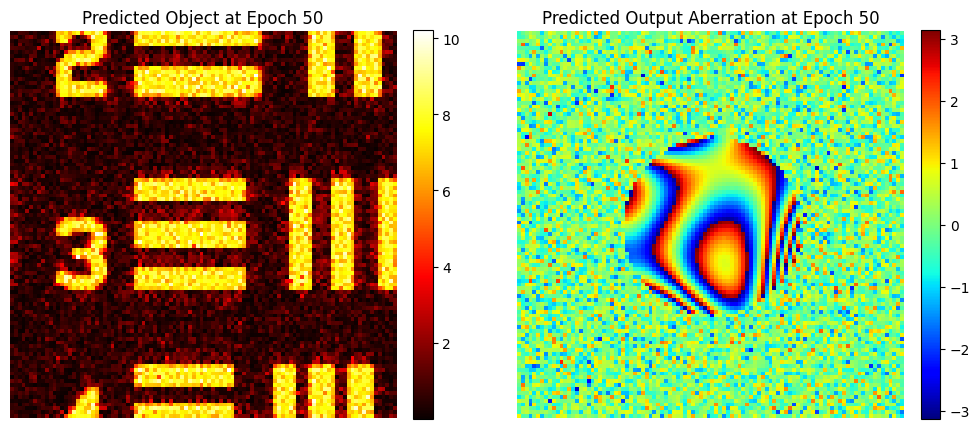

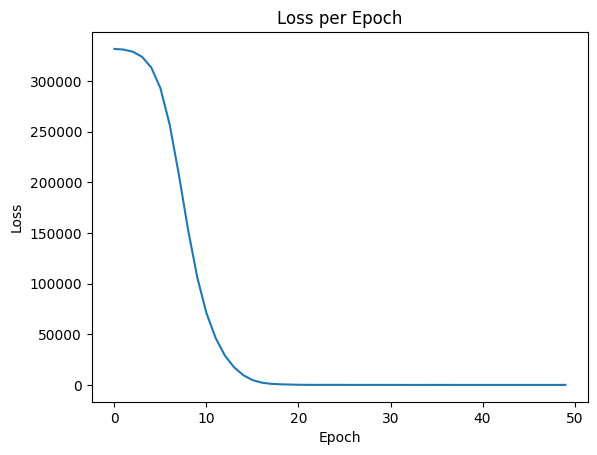

In [10]:
# Start the training loop
m = Model()
m.to(device)
optimizer = torch.optim.Adam(m.parameters(), lr=lr)

loss_hist = []
for epoch in range(num_epoch):
    loss = 0
    for Input, Output in dataloader:
        Input = Input.to(device)
        Output = Output.to(device)
        optimizer.zero_grad()
        Output_preds = m(Input)
        loss_val = MSE(Output_preds, Output) + R1 * torch.mean(abs(m.Object_()**2))
        loss_val.backward()
        optimizer.step()
        loss += loss_val.item()
    loss_hist.append(loss)

    # Every 10 epochs, clear the output and plot the predicted object and aberration
    if (epoch + 1) % 1 == 0:
        clear_output(wait=True)  # Clear previous outputs before displaying new figures
        plt.figure(figsize=(12, 6))

        # Plot the predicted object
        ax1 = plt.subplot(1, 2, 1)
        predicted_object = abs(m.Object_()).cpu().detach().numpy()
        im1 = plt.imshow(predicted_object, cmap='hot')
        plt.title(f'Predicted Object at Epoch {epoch + 1}')
        plt.gca().set_axis_off()
        plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)  # Adjust these values as needed

        # Plot the predicted output aberration
        ax2 = plt.subplot(1, 2, 2)
        predicted_aberration = np.exp(1.0j * m.output_aberration_().cpu().detach().numpy())
        im2 = plt.imshow(np.angle(predicted_aberration), cmap='jet')
        plt.title(f'Predicted Output Aberration at Epoch {epoch + 1}')
        plt.gca().set_axis_off()
        plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)  # Adjust these values as needed

        plt.show()

# Plot the overall loss history
plt.plot(loss_hist)
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


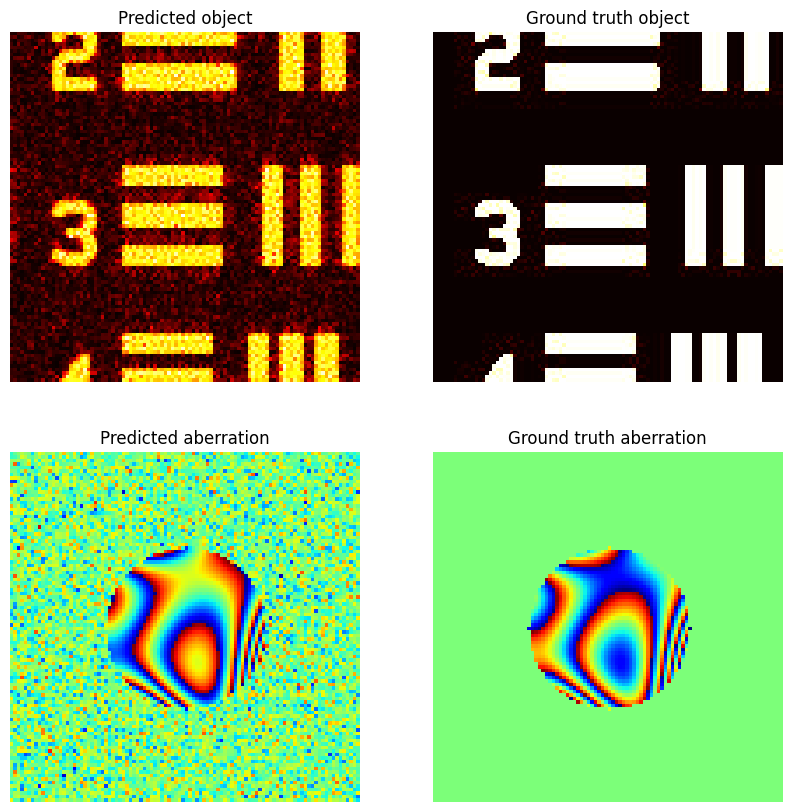

In [12]:
plt.figure(figsize=(10, 10))  # Adjust the size as needed

# Subplot for the Predicted Object
plt.subplot(2, 2, 1)
plt.imshow(abs(m.Object_()).cpu().detach().numpy(), cmap='hot')
plt.title('Predicted object')
plt.gca().set_axis_off()

# Subplot for the Ground Truth Object
plt.subplot(2, 2, 2)
plt.imshow(Object_gt, cmap='hot')
plt.title('Ground truth object')
plt.gca().set_axis_off()

# Subplot for Predicted Aberration
abo = np.exp(1.0j * m.output_aberration_().cpu().detach().numpy())
plt.subplot(2, 2, 3)
plt.imshow(np.angle(abo), cmap='jet')
plt.title('Predicted aberration')
plt.gca().set_axis_off()

# Subplot for Ground Truth Aberration
plt.subplot(2, 2, 4)
plt.imshow(np.angle(output_aberration_gt), cmap='jet')
plt.title('Ground truth aberration')
plt.gca().set_axis_off()

# Display all subplots
plt.show()
